In [ ]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import shap

In [23]:

# 1. Load Data
df = pd.read_csv("UCI_Credit_Card.csv")

# 2. Data Cleaning
# Drop ID (already dropped as index)
# Check for missing values
assert df.isnull().sum().sum() == 0, "Missing values detected!"
df.describe()
# 3. Feature Selection / Preprocessing

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,...,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,15000.500000,167484.322667,1.603733,1.853133,1.551867,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,...,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,8660.398374,129747.661567,0.489129,0.790349,0.521970,9.217904,1.123802,1.197186,1.196868,1.169139,...,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,1.000000,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,7500.750000,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,15000.500000,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,...,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,22500.250000,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,...,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,30000.000000,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,...,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


In [24]:

# 3. Feature Selection / Preprocessing
X = df.drop("default", axis=1)
y = df["default"]

# Normalize continuous variables (amounts, bill, payments)
amount_features = [
    "LIMIT_BAL", *[f"BILL_AMT{i}" for i in range(1, 7)], *[f"PAY_AMT{i}" for i in range(1, 7)]
]
scaler = StandardScaler()
X[amount_features] = scaler.fit_transform(X[amount_features])


In [25]:

# 4. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)


In [26]:
# 5. Model Training
rf = RandomForestClassifier(n_estimators=100, max_depth=10, class_weight='balanced', random_state=42)
rf.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced', max_depth=10, random_state=42)

In [27]:

# 6. Evaluation
y_pred = rf.predict(X_test)
y_proba = rf.predict_proba(X_test)[:, 1]

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print(f"ROC-AUC Score: {roc_auc_score(y_test, y_proba):.4f}")



Confusion Matrix:
[[4992  849]
 [ 719  940]]

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.85      0.86      5841
           1       0.53      0.57      0.55      1659

    accuracy                           0.79      7500
   macro avg       0.70      0.71      0.70      7500
weighted avg       0.80      0.79      0.79      7500

ROC-AUC Score: 0.7752


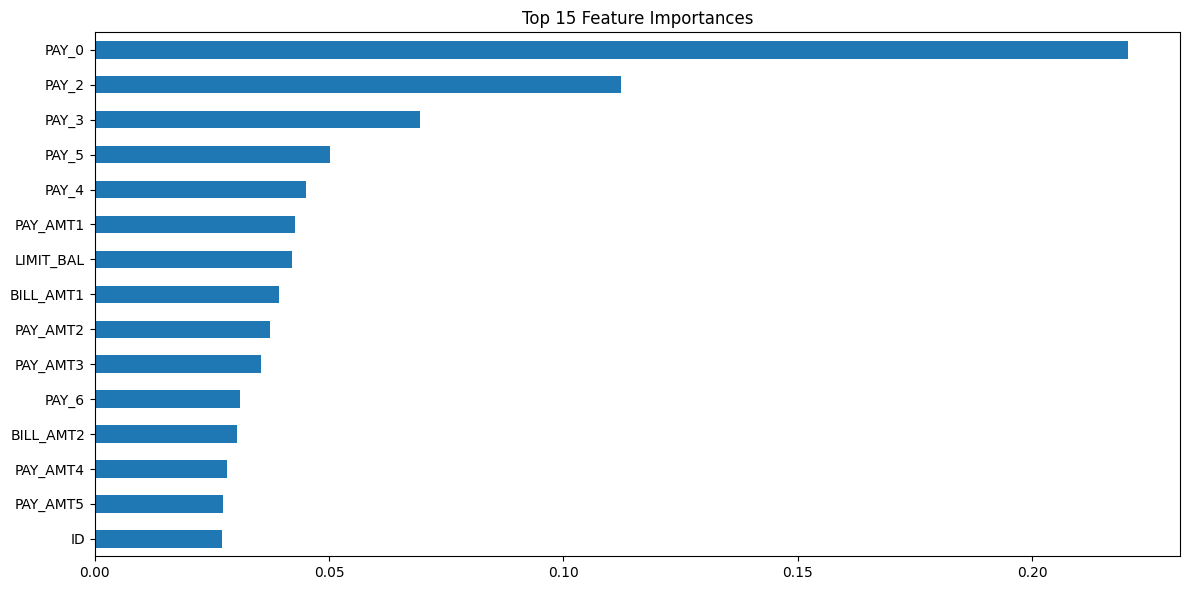

In [28]:
# 7. Feature Importance
plt.figure(figsize=(12, 6))
importances = pd.Series(rf.feature_importances_, index=X.columns)
importances.nlargest(15).sort_values().plot(kind='barh')
plt.title("Top 15 Feature Importances")
plt.tight_layout()
plt.show()


In [30]:

# 8. SHAP for Interpretability
explainer = shap.Explainer(rf, X_train)
shap_values = explainer(X_test[:100])
shap.plots.beeswarm(shap_values, max_display=15)


c:\Users\NCS\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ValueError: The beeswarm plot does not support plotting explanations with instances that have more than one dimension!